In [ ]:
# default_exp models.explainability

# Model explainability
> Functionality to help with both global and local explainability.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.utils import *

In [ ]:
from tsai.data.all import *
from tsai.models.XCM import *

dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, split_data=False)
tfms = [None, Categorize()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms)
model =  XCM(dls.vars, dls.c, dls.len)
learn = Learner(dls, model, metrics=accuracy)
xb, yb = dls.one_batch()
x = xb[0]
model.eval()(xb).shape

torch.Size([64, 6])

In [ ]:
#export
def get_acts_and_grads(model, modules, x, y=None, detach=True, cpu=False):
    r"""Returns activations and gradients for given modules in a model and a single input or a batch. 
    Gradients require y value(s). If they rae not provided, it will use the predicttions. """
    if not is_listy(modules): modules = [modules]
    x = x[None, None] if x.ndim == 1 else x[None] if x.ndim == 2 else x
    with hook_outputs(modules, detach=detach, cpu=cpu) as h_act:
        with hook_outputs(modules, grad=True, detach=detach, cpu=cpu) as h_grad:
            preds = model.eval()(x)
            if y is None: preds.max(dim=-1).values.mean().backward()
            else: 
                if preds.shape[0] == 1: preds[0, y].backward()
                else: 
                    if y.ndim == 1: y = y.reshape(-1, 1)
                    torch_slice_by_dim(preds, y).mean().backward()
    if len(modules) == 1: return h_act.stored[0].data, h_grad.stored[0][0].data
    else: return [h.data for h in h_act.stored], [h[0].data for h in h_grad.stored]


def get_attibution_map(model, modules, x, y=None, detach=True, cpu=False, apply_relu=True):
    def _get_attribution_map(A_k, w_ck):
        dim = (0, 2, 3) if A_k.ndim == 4 else (0, 2)
        w_ck = w_ck.mean(dim, keepdim=True)
        L_c = (w_ck * A_k).sum(1)
        if apply_relu: L_c = nn.ReLU()(L_c)
        if L_c.ndim == 3:  return L_c.squeeze(0) if L_c.shape[0] == 1 else L_c
        else: return L_c.repeat(x.shape[1], 1) if L_c.shape[0] == 1 else L_c.unsqueeze(1).repeat(1, x.shape[1], 1)
    if x.ndim == 1: x = x[None, None]
    elif x.ndim == 2: x = x[None]
    A_k, w_ck = get_acts_and_grads(model, modules, x, y, detach=detach, cpu=cpu)
    if is_listy(A_k): return [_get_attribution_map(A_k[i], w_ck[i]) for i in range(len(A_k))]
    else: return _get_attribution_map(A_k, w_ck)

In [ ]:
acts, grads = get_acts_and_grads(model, model.conv2dblock, x)
acts.shape, grads.shape

(torch.Size([1, 128, 24, 51]), torch.Size([1, 128, 24, 51]))

In [ ]:
acts, grads = get_acts_and_grads(model, model.conv2dblock, xb)
acts.shape, grads.shape

(torch.Size([64, 128, 24, 51]), torch.Size([64, 128, 24, 51]))

In [ ]:
acts, grads = get_acts_and_grads(model, model.conv2dblock, xb, yb)
acts.shape, grads.shape

(torch.Size([64, 128, 24, 51]), torch.Size([64, 128, 24, 51]))

In [ ]:
acts, grads = get_acts_and_grads(model, model.conv1dblock, xb)
acts.shape, grads.shape

(torch.Size([64, 128, 51]), torch.Size([64, 128, 51]))

In [ ]:
acts, grads = get_acts_and_grads(model, [model.conv2dblock, model.conv1dblock], xb, yb)
[act.shape for act in acts], [grad.shape for grad in grads]

([torch.Size([64, 128, 24, 51]), torch.Size([64, 128, 51])],
 [torch.Size([64, 128, 24, 51]), torch.Size([64, 128, 51])])

In [ ]:
att_maps = get_attibution_map(model, model.conv2dblock, xb, yb)
att_maps.shape

torch.Size([64, 24, 51])

In [ ]:
att_maps = get_attibution_map(model, model.conv1dblock, xb)
att_maps.shape

torch.Size([64, 24, 51])

In [ ]:
att_maps = get_attibution_map(model, [model.conv2dblock, model.conv1dblock], xb)
[am.shape for am in att_maps]

[torch.Size([64, 24, 51]), torch.Size([64, 24, 51])]

In [ ]:
acts, grads = get_acts_and_grads(model, [model.conv2dblock, model.conv1dblock], xb[0], yb[0], detach=True, cpu=False)
print(len(acts), len(grads), acts[0].shape, grads[0].shape)
acts, grads = get_acts_and_grads(model, model.conv2dblock, xb[0], y=None, detach=True, cpu=False)
print(acts.shape, grads.shape)

2 2 torch.Size([1, 128, 24, 51]) torch.Size([1, 128, 24, 51])
torch.Size([1, 128, 24, 51]) torch.Size([1, 128, 24, 51])


In [ ]:
att_maps = get_attibution_map(model, model.conv2dblock, x)
att_maps.shape

torch.Size([24, 51])

In [ ]:
att_maps = get_attibution_map(model, model.conv1dblock, x)
att_maps.shape

torch.Size([24, 51])

In [ ]:
att_maps = get_attibution_map(model, [model.conv2dblock, model.conv1dblock], x)
[am.shape for am in att_maps]

[torch.Size([24, 51]), torch.Size([24, 51])]

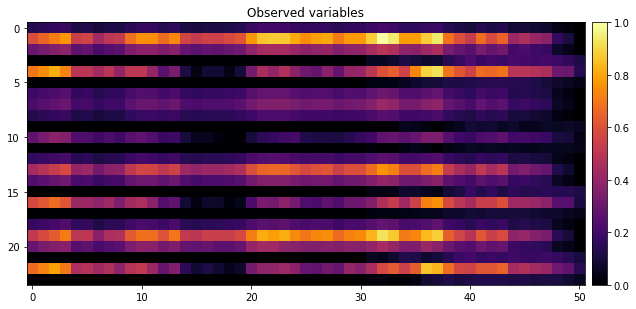

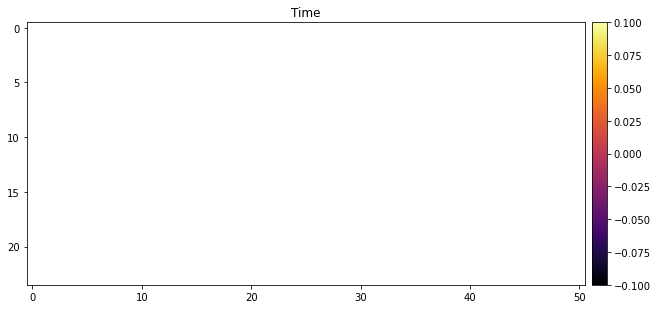

In [ ]:
att_maps = get_attibution_map(model, [model.conv2dblock, model.conv1dblock], x)
att_maps[0] = (att_maps[0] - att_maps[0].min()) / (att_maps[0].max() - att_maps[0].min())
att_maps[1] = (att_maps[1] - att_maps[1].min()) / (att_maps[1].max() - att_maps[1].min())

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
plt.title('Observed variables')
im = ax.imshow(att_maps[0], cmap='inferno')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
plt.title('Time')
im = ax.imshow(att_maps[1], cmap='inferno')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im, cax=cax)
plt.show()

In [ ]:
# '''
# Color parts of a line based on its properties, e.g., slope.
# '''

# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection
# from matplotlib.colors import ListedColormap, BoundaryNorm

# x = np.linspace(0, 3 * np.pi, 500)
# y = np.sin(x)
# z = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# # Create a colormap for red, green and blue and a norm to color
# # f' < -0.5 red, f' > 0.5 blue, and the rest green
# cmap = ListedColormap(['r', 'g', 'b'])
# norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)

# # Create a set of line segments so that we can color them individually
# # This creates the points as a N x 1 x 2 array so that we can stack points
# # together easily to get the segments. The segments array for line collection
# # needs to be numlines x points per line x 2 (x and y)
# points = np.array([x, y]).T.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)

# # Create the line collection object, setting the colormapping parameters.
# # Have to set the actual values used for colormapping separately.
# lc = LineCollection(segments, cmap=cmap, norm=norm)
# lc.set_array(z)
# lc.set_linewidth(3)

# fig1 = plt.figure()
# plt.gca().add_collection(lc)
# plt.xlim(x.min(), x.max())
# plt.ylim(-1.1, 1.1)

# # Now do a second plot coloring the curve using a continuous colormap
# t = np.linspace(0, 10, 200)
# x = np.cos(np.pi * t)
# y = np.sin(t)
# points = np.array([x, y]).T.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)

# lc = LineCollection(segments, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0, 10))
# lc.set_array(t)
# lc.set_linewidth(3)

# fig2 = plt.figure()
# plt.gca().add_collection(lc)
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
# plt.show()

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.semi_supervised.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.MLP.ipynb.
Converted 103b_models.FCN.ipynb.
Converted 103c_models.FCNPlus.ipynb.
Converted 104_models.ResCNN.ipynb.
Converted 105_models.RNN.ipynb.
Converted 105_models.RNNPlus.